# 0 - Intro
This is a notebook sample to download dataset, arrange folders, train a simple model and export it to model's folder

## Caltech-256 dataset 

Could be downloaded from [oficial website](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)

or

It can be downloaded from a public S3 from AWS with some dataset [samples](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning-highlevel.html)

## 1 - Download and arrange Data

In [110]:
import boto3
import tarfile
import os
import shutil

import numpy as np

session = boto3.Session(profile_name='test')
s3 = session.client('s3')

data_bucket = "sagemaker-sample-files"
data_prefix = "datasets/image/caltech-256/256_ObjectCategories.tar"
root = "./dataset/"
local_prefix = "256_ObjectCategories.tar"

In [117]:
# download
s3.download_file(
    data_bucket, data_prefix , root + local_prefix
)

In [118]:
# extract file
cwd = os.getcwd()
tar = tarfile.open(os.path.join(root, local_prefix), "r")
os.chdir(root)
tar.extractall()
tar.close()
os.remove(local_prefix)
os.chdir(cwd)

In [119]:
# clean objects that was not on list
classes = ['010.beer-mug','041.coffee-mug','212.teapot','246.wine-bottle']
new_dir = root + "256_ObjectCategories"
for i in os.listdir(new_dir):
    if not i in classes:
        shutil.rmtree(os.path.join(new_dir, i))

In [122]:
# create destination folders
new_destination = root + "Caltech-256" 
if not os.path.isdir(new_destination): os.mkdir(new_destination)
if not os.path.isdir(new_destination + "/train"): os.mkdir(new_destination + "/train")
if not os.path.isdir(new_destination + "/test"): os.mkdir(new_destination + "/test")
for i in classes:
    if not os.path.isdir(new_destination + "/train/" + i): os.mkdir(new_destination + "/train/" + i)
    if not os.path.isdir(new_destination + "/test/" + i): os.mkdir(new_destination + "/test/" + i)

In [123]:
# arrange into new folder structure
for i in os.listdir(new_dir):
    for j in os.listdir(os.path.join(new_dir, i)):
        #print(os.path.join(new_dir, i, j))
        if np.random.rand(1) < 0.2:
            os.rename(os.path.join(new_dir, i, j),
                os.path.join(new_destination,'test',i,j))
            #print("test",os.path.join(new_dir,'test',i,j))
        else:
            os.rename(os.path.join(new_dir, i, j),
                os.path.join(new_destination,'train',i,j))
            #print("train",os.path.join(new_dir,'train',i,j))

In [126]:
# Delete Old folder
if os.path.isdir(new_dir): shutil.rmtree(new_dir)

In [141]:
# Rename dirs (one time only)
os.rename(os.path.join(new_destination,'train','010.beer-mug'),
    os.path.join(new_destination,'train','01.beer-mug'))
os.rename(os.path.join(new_destination,'test','010.beer-mug'),
    os.path.join(new_destination,'test','01.beer-mug'))
os.rename(os.path.join(new_destination,'train','041.coffee-mug'),
    os.path.join(new_destination,'train','02.coffee-mug'))
os.rename(os.path.join(new_destination,'test','041.coffee-mug'),
    os.path.join(new_destination,'test','02.coffee-mug'))
os.rename(os.path.join(new_destination,'train','212.teapot'),
    os.path.join(new_destination,'train','03.teapot'))
os.rename(os.path.join(new_destination,'test','212.teapot'),
    os.path.join(new_destination,'test','03.teapot'))
os.rename(os.path.join(new_destination,'train','246.wine-bottle'),
    os.path.join(new_destination,'train','04.wine-bottle'))
os.rename(os.path.join(new_destination,'test','246.wine-bottle'),
    os.path.join(new_destination,'test','04.wine-bottle'))

## 2 - Training

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [143]:
# load images into tensors
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset/Caltech-256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

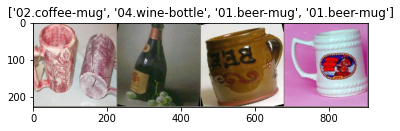

['01.beer-mug', '02.coffee-mug', '03.teapot', '04.wine-bottle']


In [147]:
# Optional, only to see few samples
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

print(class_names)

In [148]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [149]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [160]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 4), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

model_ft = model_ft.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/egfranco/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [161]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 1.1855 Acc: 0.4370
test Loss: 0.6345 Acc: 0.8701

Epoch 1/11
----------
train Loss: 0.7126 Acc: 0.7742
test Loss: 0.3037 Acc: 0.9221

Epoch 2/11
----------
train Loss: 0.5259 Acc: 0.8182
test Loss: 0.2504 Acc: 0.8831

Epoch 3/11
----------
train Loss: 0.4555 Acc: 0.8446
test Loss: 0.1787 Acc: 0.9351

Epoch 4/11
----------
train Loss: 0.4937 Acc: 0.8358
test Loss: 0.2237 Acc: 0.9740

Epoch 5/11
----------
train Loss: 0.4140 Acc: 0.8475
test Loss: 0.1751 Acc: 0.9481

Epoch 6/11
----------
train Loss: 0.3172 Acc: 0.8886
test Loss: 0.1864 Acc: 0.9091

Epoch 7/11
----------
train Loss: 0.2870 Acc: 0.9120
test Loss: 0.2114 Acc: 0.9091

Epoch 8/11
----------
train Loss: 0.3029 Acc: 0.9120
test Loss: 0.2046 Acc: 0.9221

Epoch 9/11
----------
train Loss: 0.2704 Acc: 0.9091
test Loss: 0.2000 Acc: 0.9091

Epoch 10/11
----------
train Loss: 0.3203 Acc: 0.8827
test Loss: 0.1762 Acc: 0.9091

Epoch 11/11
----------
train Loss: 0.3068 Acc: 0.8886
test Loss: 0.2632 Acc

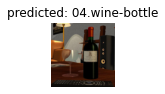

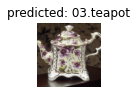

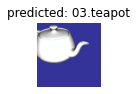

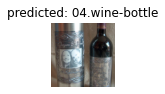

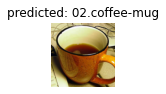

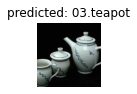

In [162]:
visualize_model(model_ft)

## 3 - Export Model

In [163]:
def save_model(model, model_dir):
    path = os.path.join(model_dir, 'model.pth')
    print(path)
    torch.save(model.state_dict(), path)

In [164]:
save_model(model_ft, './model')

./model/model.pth
